<a href="https://colab.research.google.com/github/String-ru/AIFFEL_quest_cr/blob/main/Exploration/Quest02/0410_better_be_good_text_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step2에 대해 다음과 같은 사항들을 수정했다.

1. 토크나이저에 OOV(Out-Of-Vocabulary) 토큰을 추가 => 알 수 없는 단어를 처리

2. 특수 토큰('sostoken', 'eostoken')을 먼저 토크나이저에 명시적으로 추가

3. 수동으로 각 시퀀스에 시작 토큰과 종료 토큰을 추가

디코더 입력에는 시작 토큰을 시퀀스 앞에 추가

디코더 타겟에는 종료 토큰을 시퀀스 뒤에 추가

4. 특수 토큰의 인덱스를 출력하여 디버깅 도움

### 특별히 2번 사항에 대하여...

기존 방식(문자열로 추가 후 토큰화):

먼저 일반 텍스트에 대해 토크나이저를 학습시킵니다.
이후 'sostoken'과 'eostoken'을 문자열로 데이터에 추가합니다.
이렇게 하면 두 특수 토큰은 다른 모든 단어들이 인덱스를 할당받은 후에 처리됩니다.
결과적으로, 이 특수 토큰들이 토크나이저의 단어 인덱스에서 높은 인덱스 번호를 가질 가능성이 높습니다.
또한 데이터셋에 따라 이 토큰들이 학습 과정에서 드물게 등장할 경우, 모델이 이들의 중요성을 제대로 파악하지 못할 수 있습니다.

새 방식(명시적으로 먼저 추가):

토크나이저를 학습시키기 전에 특수 토큰을 먼저 명시적으로 추가합니다.
이렇게 하면 특수 토큰이 낮은 인덱스 번호(보통 1, 2)를 가지게 됩니다.
낮은 인덱스를 가진 토큰은 임베딩 레이어에서 더 안정적으로 학습되는 경향이 있습니다.
또한 모든 시퀀스에 이러한 특수 토큰이 일관되게 적용되므로, 모델이 시작과 끝을 명확하게 인식할 수 있습니다.
특수 토큰의 인덱스가 고정되어 있으므로 디코딩 과정에서 더 정확하게 제어할 수 있습니다.

이러한 차이점은 시퀀스-투-시퀀스 모델에서 중요한 영향을 미칠 수 있습니다. 특히 디코딩 과정에서 'sostoken'은 생성 시작의 신호로, 'eostoken'은 생성 종료의 신호로 작용해야 하는데, 이들이 일관된 인덱스를 갖고 명확하게 처리되지 않으면 모델의 학습과 추론 과정에서 혼란이 발생할 수 있습니다.

## Step 1. 데이터 수집하기

Installing summa...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=3cf0651ecfb8c1f8fd15bb63d8f8b826b1cee27f13b2232de4a96a2bddafd126
  Stored in directory: /root/.cache/pip/wheels/10/2d/7a/abce87c4ea233f8dcca0d99b740ac0257eced1f99a124a0e1f
Successfully built summa
NLTK Version: 3.9.1
TensorFlow Version: 2.18.0
Pandas Version: 2.2.2
Summa Version: 1.2.0


Dataset loaded. Displaying 5 random samples:
                                               headlines  \
29849  Ronaldo named most famous athlete again, Kohli...   
64519  'Judwaa 2' becomes 2nd highest grossing Hindi ...   
31124  20 IITians move SC against law making homosexu...   
23330  28 Indians arrested in Nepal over grey market ...   
54616       Man creates functional Rubik's Cube from ice   

                                                    text  
29849  Real Madrid for

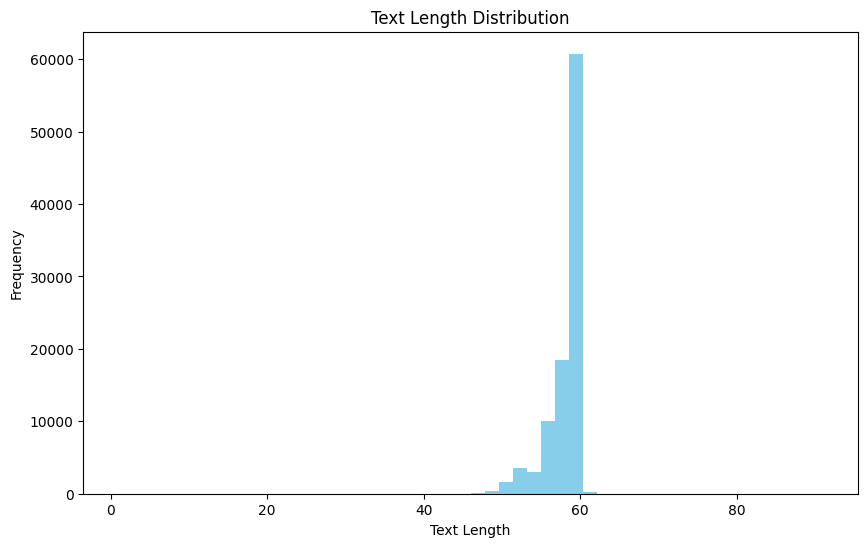

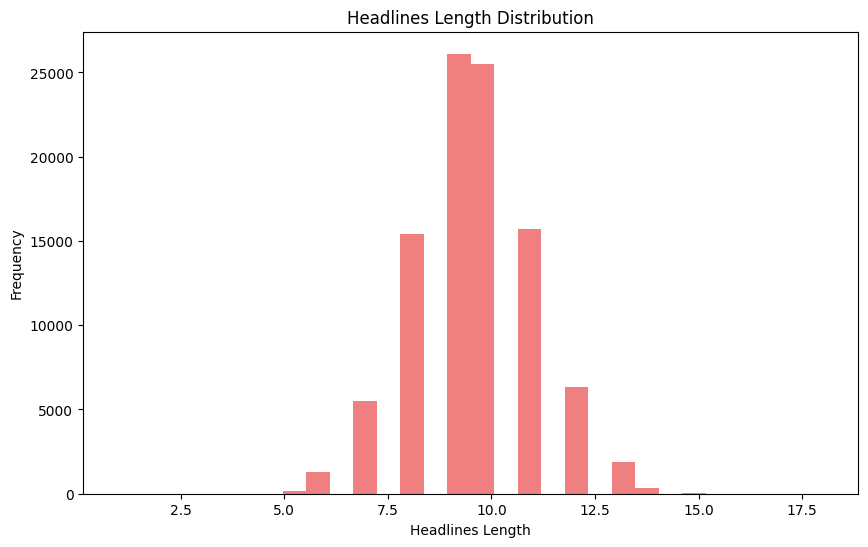


Most common words in Text: [('the', 333652), ('to', 144588), ('a', 137070), ('in', 128523), ('of', 121203), ('and', 106392), ('on', 71346), ('has', 56232), ('for', 55333), ('that', 50298), ('was', 47259), ('is', 40428), ('he', 35032), ('by', 34829), ('said', 33008), ('with', 32692), ('his', 31159), ('after', 28223), ('from', 28024), ('as', 27762)]
Most common words in Headlines: [('to', 31291), ('in', 26194), ('for', 15284), ('of', 13212), ('on', 12543), ('with', 5674), ('a', 5186), ('after', 5154), ('at', 5051), ('from', 4522), ('over', 4395), ('as', 4128), ('by', 4022), ('us', 3954), ('the', 3771), ('india', 3663), ('not', 2983), ('be', 2982), ('is', 2977), ('man', 2968)]


In [1]:
from importlib.metadata import version
import nltk
import tensorflow as tf
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from collections import Counter

# Summa 설치
print("Installing summa...")
!pip install summa
import summa

print("NLTK Version:", nltk.__version__)
print("TensorFlow Version:", tf.__version__)
print("Pandas Version:", pd.__version__)
print("Summa Version:", version('summa'))

# 데이터 다운로드 및 로드
print("\nDownloading the dataset...")
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print("\nDataset loaded. Displaying 5 random samples:")
print(data.sample(5))

# 데이터 분석
print("\n--- 데이터 분석 ---")
print("\n전체 데이터 개수:", len(data))
print("\nText 열 null 값 개수:", data['text'].isnull().sum())
print("Headlines 열 null 값 개수:", data['headlines'].isnull().sum())

# 텍스트 길이 분포 확인
text_len = data['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(text_len, bins=50, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# 헤드라인 길이 분포 확인
headlines_len = data['headlines'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(headlines_len, bins=30, color='lightcoral')
plt.title('Headlines Length Distribution')
plt.xlabel('Headlines Length')
plt.ylabel('Frequency')
plt.show()

# 가장 자주 등장하는 단어 확인 (Text)
all_text_words = ' '.join(data['text']).lower().split()
text_word_counts = Counter(all_text_words)
most_common_text_words = text_word_counts.most_common(20)
print("\nMost common words in Text:", most_common_text_words)

# 가장 자주 등장하는 단어 확인 (Headlines)
all_headlines_words = ' '.join(data['headlines']).lower().split()
headlines_word_counts = Counter(all_headlines_words)
most_common_headlines_words = headlines_word_counts.most_common(20)
print("Most common words in Headlines:", most_common_headlines_words)

## Step 2. 데이터 전처리하기 (추상적 요약)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


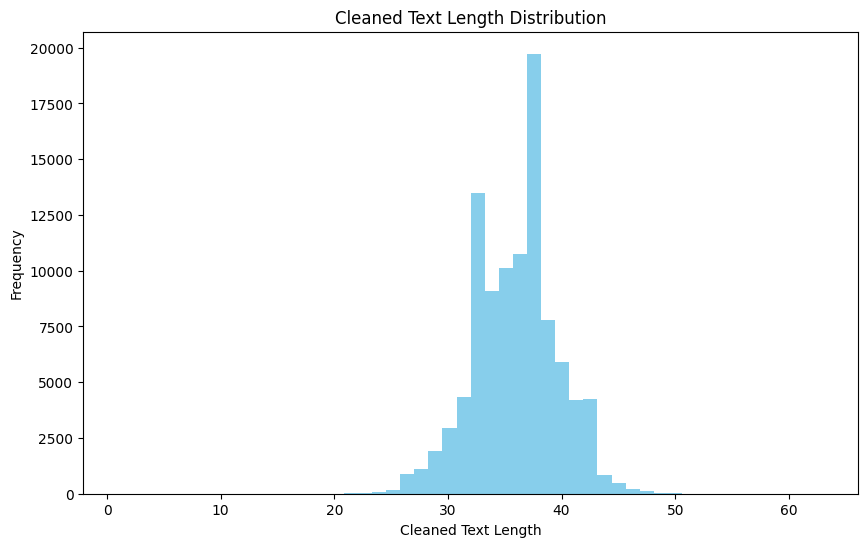

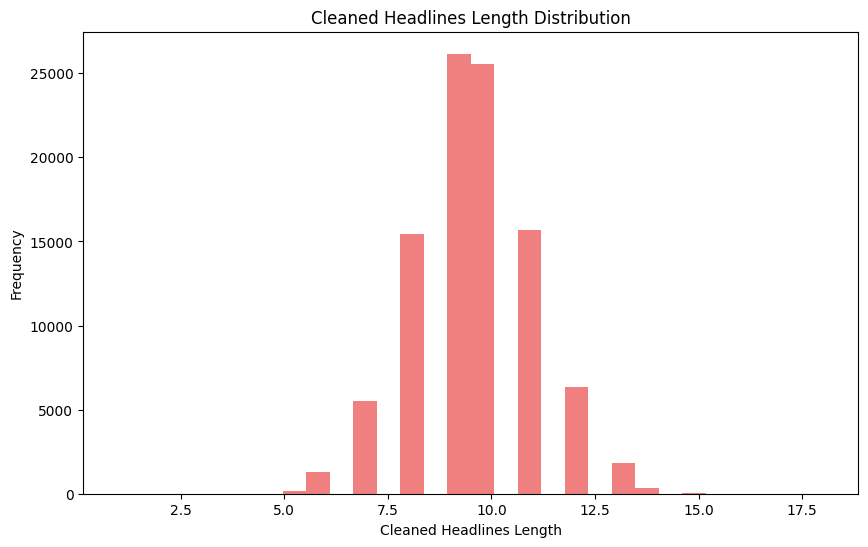

sostoken index: 25742, eostoken index: 25743

--- 데이터 전처리 완료 ---
Padded Text (Train) shape: (88560, 100)
Padded Text (Validation) shape: (9841, 100)
Padded Decoder Input (Train) shape: (88560, 20)
Padded Decoder Input (Validation) shape: (9841, 20)
Padded Decoder Target (Train) shape: (88560, 20)
Padded Decoder Target (Validation) shape: (9841, 20)
Text Vocabulary Size: 120191
Headlines Vocabulary Size: 44555


In [2]:
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([w for w in text.split() if len(w) > 1 and w not in stop_words]) # 불용어 제거
    return text

def preprocess_headlines(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 전처리 적용
data['cleaned_text'] = data['text'].apply(preprocess_text)
data['cleaned_headlines'] = data['headlines'].apply(preprocess_headlines)

# 빈 값 제거
data.replace('', float('NaN'), inplace=True)
data.dropna(axis=0, inplace=True)

# 텍스트 및 헤드라인 길이 분포 재확인 (전처리 후)
cleaned_text_len = data['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(cleaned_text_len, bins=50, color='skyblue')
plt.title('Cleaned Text Length Distribution')
plt.xlabel('Cleaned Text Length')
plt.ylabel('Frequency')
plt.show()

cleaned_headlines_len = data['cleaned_headlines'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(cleaned_headlines_len, bins=30, color='lightcoral')
plt.title('Cleaned Headlines Length Distribution')
plt.xlabel('Cleaned Headlines Length')
plt.ylabel('Frequency')
plt.show()

# 토큰화 및 패딩
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len_text = 100
max_len_headlines = 20

# Text 토크나이저
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(data['cleaned_text'])
text_sequences = text_tokenizer.texts_to_sequences(data['cleaned_text'])
padded_text = pad_sequences(text_sequences, maxlen=max_len_text, padding='post')
text_vocab_size = len(text_tokenizer.word_index) + 1

### 여기부터 수정

# 헤드라인 토크나이저 - 특수 토큰 사전 추가
headlines_tokenizer = Tokenizer(oov_token='<OOV>')
# 특수 토큰을 위한 텍스트 데이터 준비
special_tokens = ['sostoken', 'eostoken']
all_headlines = list(data['cleaned_headlines'])
# 토크나이저 학습
headlines_tokenizer.fit_on_texts(special_tokens + all_headlines)

# 특수 토큰 인덱스 확인
sostoken_index = headlines_tokenizer.word_index['sostoken']
eostoken_index = headlines_tokenizer.word_index['eostoken']
print(f"sostoken index: {sostoken_index}, eostoken index: {eostoken_index}")

# 일반 헤드라인 시퀀스 변환
headlines_sequences = headlines_tokenizer.texts_to_sequences(data['cleaned_headlines'])
padded_headlines = pad_sequences(headlines_sequences, maxlen=max_len_headlines, padding='post')

# 디코더 입력 시퀀스 생성 (시작 토큰 추가)
decoder_input_sequences = []
for seq in headlines_sequences:
    decoder_input_sequences.append([sostoken_index] + seq)
padded_decoder_input = pad_sequences(decoder_input_sequences, maxlen=max_len_headlines, padding='post')

# 디코더 타겟 시퀀스 생성 (종료 토큰 추가)
decoder_target_sequences = []
for seq in headlines_sequences:
    decoder_target_sequences.append(seq + [eostoken_index])
padded_decoder_target = pad_sequences(decoder_target_sequences, maxlen=max_len_headlines, padding='post')

# 어휘 크기 업데이트
headlines_vocab_size = len(headlines_tokenizer.word_index) + 1

### 여기까지 수정

decoder_target_sequences = headlines_tokenizer.texts_to_sequences(data['cleaned_headlines'])
padded_decoder_target = pad_sequences(decoder_target_sequences, maxlen=max_len_headlines, padding='post')

# 데이터셋 분리
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(padded_text, padded_decoder_target, test_size=0.1, random_state=42)
x_decoder_train, x_decoder_val, y_decoder_train, y_decoder_val = train_test_split(padded_decoder_input, padded_decoder_target, test_size=0.1, random_state=42)

print("\n--- 데이터 전처리 완료 ---")
print("Padded Text (Train) shape:", x_train.shape)
print("Padded Text (Validation) shape:", x_val.shape)
print("Padded Decoder Input (Train) shape:", x_decoder_train.shape)
print("Padded Decoder Input (Validation) shape:", x_decoder_val.shape)
print("Padded Decoder Target (Train) shape:", y_train.shape)
print("Padded Decoder Target (Validation) shape:", y_val.shape)
print("Text Vocabulary Size:", text_vocab_size)
print("Headlines Vocabulary Size:", headlines_vocab_size)

## Step 3. 어텐션 메커니즘을 사용한 Seq2Seq 모델 설계 및 학습 (추상적 요약)

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

K.clear_session()
latent_dim = 256

# 인코더
encoder_inputs = layers.Input(shape=(max_len_text,))
enc_emb = layers.Embedding(text_vocab_size, latent_dim)(encoder_inputs)
encoder_lstm1 = layers.LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_lstm2 = layers.LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
encoder_outputs, state_h, state_c = layers.LSTM(latent_dim, return_sequences=True, return_state=True)(encoder_outputs2)

# 디코더
decoder_inputs = layers.Input(shape=(None,))
dec_emb_layer = layers.Embedding(headlines_vocab_size, latent_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = layers.LSTM(latent_dim, return_sequences=True, return_state=True)(dec_emb, initial_state=[state_h, state_c])

# 어텐션 메커니즘
attention_layer = layers.AdditiveAttention(name='attention_layer')
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = layers.Concatenate(axis=-1)([decoder_outputs, attention_outputs])

# 출력층
decoder_dense = layers.TimeDistributed(layers.Dense(headlines_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# 모델 정의
model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 256)  │ 30,768,896 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 100,      │    525,312 │ embedding[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 100,      │    525,312 │ lstm[0][0]        │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │ 11,406,080 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 100,      │    525,312 │ lstm_1[0][0]      │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, None,     │    525,312 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 256) │        256 │ lstm_4[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 512) │          0 │ lstm_4[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │ 22,856,715 │ concatenate[0][0] │
│ (TimeDistributed)   │ 44555)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,133,195 (256.09 MB)

 Trainable params: 67,133,195 (256.09 MB)

 Non-trainable params: 0 (0.00 B)

### 모델 컴파일 및 학습

Epoch 1/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 281s 193ms/step - loss: 4.3027 - val_loss: 3.8651
Epoch 2/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 318s 194ms/step - loss: 3.8020 - val_loss: 3.7322
Epoch 3/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 322s 194ms/step - loss: 3.6388 - val_loss: 3.5692
Epoch 4/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 322s 195ms/step - loss: 3.4397 - val_loss: 3.4183
Epoch 5/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 321s 194ms/step - loss: 3.3014 - val_loss: 3.3156
Epoch 6/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 323s 195ms/step - loss: 3.1657 - val_loss: 3.2219
Epoch 7/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 321s 194ms/step - loss: 3.0372 - val_loss: 3.1241
Epoch 8/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 270s 195ms/step - loss: 2.9217 - val_loss: 3.0611
Epoch 9/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 322s 195ms/step - loss: 2.8210 - val_loss: 3.0118
Epoch 10/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 270s 195ms/step - loss: 2.7298 - val_loss: 2.9657
Epoch 11/15
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 321s 194ms/step - loss: 2.6486 - val

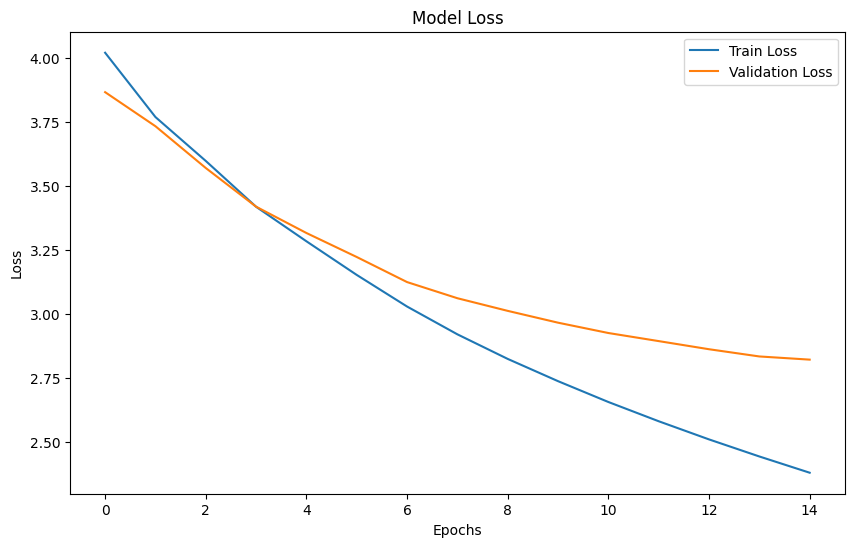

In [4]:
# 모델 컴파일
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit([x_train, x_decoder_train], y_train.reshape((-1, y_train.shape[1], 1)),
                    epochs=15, callbacks=[es], batch_size=64,
                    validation_data=([x_val, x_decoder_val], y_val.reshape((-1, y_val.shape[1], 1))))

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 예측을 위한 모델 재구성
encoder_model = models.Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = layers.Input(shape=(latent_dim,))
decoder_state_input_c = layers.Input(shape=(latent_dim,))
decoder_hidden_state_input = layers.Input(shape=(max_len_text, latent_dim,))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
attention_outputs_inf = attention_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_concat_input_inf = layers.Concatenate(axis=-1)([decoder_outputs2, attention_outputs_inf])
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)
decoder_model = models.Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2])

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [5]:
# 요약 생성 함수
def decode_sequence(input_seq):
    # 인코더로 입력 시퀀스를 인코딩
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)

    # 디코더의 초기 입력 (시작 토큰)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = headlines_tokenizer.word_index['sostoken']  # 명시적 인덱스 사용

    # 디코더의 초기 상태는 인코더의 최종 상태
    h = e_h
    c = e_c

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더로 다음 단어 예측
        output_tokens, h, c = decoder_model.predict([target_seq, e_out, h, c], verbose=0)

        # 가장 확률이 높은 단어 선택
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = headlines_tokenizer.index_word.get(sampled_token_index)

        # eostoken이 아니면 결과 문장에 추가
        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 중지 조건: eostoken이거나 최대 길이에 도달
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (max_len_headlines - 1):
            stop_condition = True

        # 다음 타임스텝을 위한 타겟 시퀀스 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return decoded_sentence.strip()

In [6]:
import numpy as np

# 원본 텍스트와 실제 헤드라인을 정수 시퀀스에서 텍스트로 변환하는 함수 (기존 코드 활용)
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if((i!=0 and i!=headlines_tokenizer.word_index['sostoken']) and i!=headlines_tokenizer.word_index['eostoken']):
            newString = newString + headlines_tokenizer.index_word[i] + ' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+text_tokenizer.index_word[i]+' '
    return newString

# 검증 데이터셋의 처음 몇 개 샘플에 대한 요약 결과 확인 및 출력
for i in range(0, 5): # 출력 개수를 조절할 수 있습니다.
    original_text = seq2text(x_val[i])
    actual_summary = seq2summary(y_val[i])
    predicted_summary = decode_sequence(x_val[i].reshape(1, max_len_text))

    print("원문 :", original_text)
    print("실제 요약 :", actual_summary)
    print("예측 요약 :", predicted_summary)
    print("\n")

원문 : students karnataka get extra marks parents cast votes upcoming assembly elections associated management primary secondary schools announced encouraging marks added 201819 academic year association said casting votes parents visit member schoolsand confirm voted showing indelible ink mark 
실제 요약 : ktaka students to get extra marks if parents vote in polls 
예측 요약 : student karnataka karnataka karnataka karnataka karnataka karnataka karnataka karnataka karnataka ktaka ktaka ktaka students students students students students students


원문 : syrian antiaircraft defences monday shot missiles two air bases syrias state media said missiles targeted shayrat air base homs province another base northeast capital damascus comes days us uk france launched air strikes syrian chemical weapons facilities retaliation alleged chemical attack douma 
실제 요약 : syria shoots down missiles fired at two air bases 
예측 요약 : us us us us us us us us russia russia russia russia russia russia russia russia russi

## Step 5. Summa을 이용해서 추출적 요약해보기

In [8]:
from summa.summarizer import summarize
import pandas as pd
from importlib.metadata import version

print("Summa Version:", version('summa'))

# Step 1: 데이터 로드 (이전 단계에서 로드된 'data' DataFrame 사용)
# Ensure 'data' DataFrame is loaded and contains 'text' and 'headlines' columns

# Step 2: 추출적 요약 함수 정의 (비율 및 단어 수 조정 옵션 추가)
def extractive_summarization_summa(text, ratio=None, words=None):
    """
    Summa 라이브러리를 사용하여 텍스트에서 추출적 요약을 생성합니다.

    Args:
        text (str): 요약할 원본 텍스트입니다.
        ratio (float, optional): 요약문의 비율 (0.0 ~ 1.0). Defaults to None.
        words (int, optional): 요약문의 최대 단어 수. Defaults to None.

    Returns:
        str: 추출된 요약문입니다.
    """
    try:
        if ratio:
            summary = summarize(text, ratio=ratio)
        elif words:
            summary = summarize(text, words=words)
        else:
            summary = summarize(text)  # 기본 동작 (Summa가 자동 결정)
        return summary
    except Exception as e:
        print(f"Summa 요약 오류: {e}")
        return ""

# Step 3: 다양한 설정으로 추출적 요약 적용
data['summa_summary_ratio_03'] = data['text'].apply(lambda x: extractive_summarization_summa(x, ratio=0.3))
data['summa_summary_words_30'] = data['text'].apply(lambda x: extractive_summarization_summa(x, words=30))
data['summa_summary_raw'] = data['text'].apply(extractive_summarization_summa) # 전처리된 텍스트 사용

# Step 4: 결과 확인 (처음 몇 개 샘플 출력)
print("\n--- Summa를 이용한 다양한 설정의 추출적 요약 결과 (처음 5개 샘플) ---")
for i in range(5):
    print(f"\n--- 샘플 {i+1} ---")
    print(f"\n원문:\n{data['text'][i]}")
    print(f"\nSumma 요약 (비율=0.3):\n{data['summa_summary_ratio_03'][i]}")
    print(f"\nSumma 요약 (단어 수=30):\n{data['summa_summary_words_30'][i]}")
    print(f"\nSumma 요약 (기본 설정):\n{data['summa_summary_raw'][i]}")
    print(f"\n실제 헤드라인:\n{data['headlines'][i]}")

Summa Version: 1.2.0

--- Summa를 이용한 다양한 설정의 추출적 요약 결과 (처음 5개 샘플) ---

--- 샘플 1 ---

원문:
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

Summa 요약 (비율=0.3):


Summa 요약 (단어 수=30):
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.

Summa 요약 (기본 설정):


실제 헤드라인:
upGrad learner switches to career in ML & Al with 90% salary hike

--- 샘플 2 ---

원문:
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 200